## **Tutorial: Brain MRI Image Prediction
1. Getting image data in, preprocessing it, and fitting a model



In [0]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications  import VGG19, ResNet50, InceptionV3



In [6]:
# After saving the following zip file to your working directory extract all files and folders from zip file to local folder.

!unzip brain_tumor_dataset.zip  


Archive:  brain_tumor_dataset.zip
   creating: brain_tumor_dataset/no/
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brai

In [7]:
# Extracting all filenames iteratively from brain_tumor_dataset folder
base_path = 'brain_tumor_dataset'
categories = ['yes', 'no']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:4]) #examples of file names

number of images for each category: [155, 98]
[['brain_tumor_dataset/yes/Y109.JPG', 'brain_tumor_dataset/yes/Y36.JPG', 'brain_tumor_dataset/yes/Y100.JPG', 'brain_tumor_dataset/yes/Y70.jpg', 'brain_tumor_dataset/yes/Y33.jpg', 'brain_tumor_dataset/yes/Y183.jpg', 'brain_tumor_dataset/yes/Y73.jpg', 'brain_tumor_dataset/yes/Y42.jpg', 'brain_tumor_dataset/yes/Y67.JPG', 'brain_tumor_dataset/yes/Y115.JPG', 'brain_tumor_dataset/yes/Y53.jpg', 'brain_tumor_dataset/yes/Y46.jpg', 'brain_tumor_dataset/yes/Y259.JPG', 'brain_tumor_dataset/yes/Y250.jpg', 'brain_tumor_dataset/yes/Y39.jpg', 'brain_tumor_dataset/yes/Y245.jpg', 'brain_tumor_dataset/yes/Y27.jpg', 'brain_tumor_dataset/yes/Y51.jpg', 'brain_tumor_dataset/yes/Y147.JPG', 'brain_tumor_dataset/yes/Y159.JPG', 'brain_tumor_dataset/yes/Y8.jpg', 'brain_tumor_dataset/yes/Y9.jpg', 'brain_tumor_dataset/yes/Y15.jpg', 'brain_tumor_dataset/yes/Y19.JPG', 'brain_tumor_dataset/yes/Y101.jpg', 'brain_tumor_dataset/yes/Y62.jpg', 'brain_tumor_dataset/yes/Y162.jpg'

In [8]:
# Let's explore the details of the image data using load_img from keras
from keras.preprocessing import image
from keras.preprocessing.image import load_img
import numpy as np
from PIL import Image

img = load_img('brain_tumor_dataset/yes/Y26.jpg')
# report details about the image
print(type(img))
print(img.format)
print(img.mode)
print(img.size)

# It's an RGB image, so we can import using the following approach.

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(628, 630)


Using TensorFlow backend.


In [0]:
# Import image, load to array of shape height, width, channels, then min/max transform.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def load_image(img_path):
        img = Image.open(img_path).convert("RGB").resize((224,224)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-np.float32(img).min())/(np.float32(img).max()-np.float32(img).min()) # min max transformation
        img=img.reshape((224,224,3)) # Create final shape as array with correct dimensions for Keras
        return img

# read in all images from filenames

preprocessed_image_data=list(map(load_image, fnames[0]+fnames[1])) 

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model


In [10]:
print(len(preprocessed_image_data) ) #same number of elements as filenames
print(preprocessed_image_data[0].shape ) #dimensions now 192,192,3 for all images
print(preprocessed_image_data[0].min() ) #min value of every image is zero
print(preprocessed_image_data[0].max() ) #max value of every image is one
X.shape # 

253
(224, 224, 3)
0.0
1.0


(253, 224, 224, 3)

In [11]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

yes=list(repeat("yes", 155))
no=list(repeat("no", 98))


#combine into single list of y labels
y_labels = yes+no

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

253


,no,yes
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
248,1,0
249,1,0
250,1,0
251,1,0


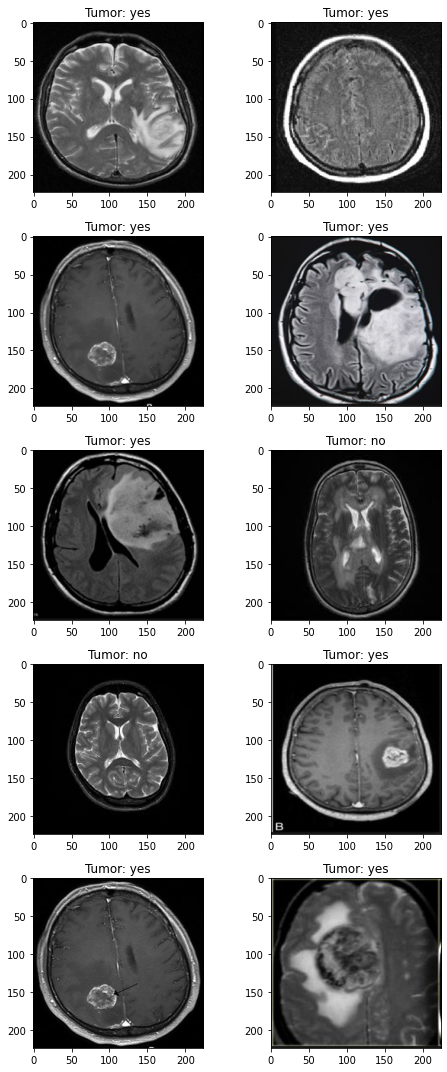

In [12]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(7,15)
for i in range(5):
    for j in range (2):
        l= np.random.randint(0,len(y_labels))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Tumor: '+y_labels[l])
        
plt.tight_layout()

In [13]:
# Train test split resized images
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)


y_train 



,no,yes
38,0,1
143,0,1
84,0,1
55,0,1
217,1,0
...,...,...
106,0,1
14,0,1
92,0,1
179,1,0


## Back to example code for Keras Convolutional Neural Net:

In [14]:
# Let's set a baseline plain vanilla network model to use as a baseline for convnet models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.callbacks import ModelCheckpoint


with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      opt=SGD(lr=.001)

      model = Sequential()
      model.add(Dense(64,  input_shape=(224, 224, 3), activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Flatten())
      model.add(Dense(2, activation='softmax')) 

  
      mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
      red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs                                                
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      # Fitting the NN to the Training set
      model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])

Epoch 1/5
7/7 [==============================] - ETA: 0s - loss: 0.6236 - accuracy: 0.6485
Epoch 00001: val_accuracy improved from -inf to 0.78431, saving model to best_model.h5
7/7 [==============================] - 2s 264ms/step - loss: 0.6236 - accuracy: 0.6485 - val_loss: 0.6301 - val_accuracy: 0.7843 - lr: 0.0010
Epoch 2/5
7/7 [==============================] - ETA: 0s - loss: 0.5667 - accuracy: 0.6931
Epoch 00002: val_accuracy did not improve from 0.78431
7/7 [==============================] - 2s 227ms/step - loss: 0.5667 - accuracy: 0.6931 - val_loss: 0.7385 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 3/5
7/7 [==============================] - ETA: 0s - loss: 0.5491 - accuracy: 0.7475
Epoch 00003: val_accuracy did not improve from 0.78431

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.001.
7/7 [==============================] - 2s 228ms/step - loss: 0.5491 - accuracy: 0.7475 - val_loss: 0.6305 - val_accuracy: 0.6275 - lr: 0.0010
Epoch 4/5
7/7 [========================

In [77]:

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

   model = tf.keras.Sequential([
      # input: images of size 192x192x3 pixels (the three stands for RGB channels)    
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=[224, 224, 3]),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
      tf.keras.layers.Flatten(),
      # classifying into 2 categories
      tf.keras.layers.Dense(2, activation='softmax')
    ])
    #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
    #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

   model.compile(
      optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
      loss= 'categorical_crossentropy',
      metrics=['accuracy'])
    
    # Fitting the CNN to the Training set
   model.fit(X_train, y_train, 
                      epochs = 5, verbose=1,validation_data=(X_test,y_test)) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/5
7/7 [==============================] - 1s 106ms/step - loss: 0.6743 - accuracy: 0.5941 - val_loss: 0.7017 - val_accuracy: 0.5294
Epoch 2/5
7/7 [==============================] - 1s 87ms/step - loss: 0.6305 - accuracy: 0.6337 - val_loss: 0.7073 - val_accuracy: 0.5294
Epoch 3/5
7/7 [==============================] - 1s 89ms/step - loss: 0.6244 - accuracy: 0.6337 - val_loss: 0.6877 - val_accuracy: 0.5294
Epoch 4/5
7/7 [==============================] - 1s 89ms/step - loss: 0.6129 - accuracy: 0.6337 - val_loss: 0.6983 - val_accuracy: 0.5294
Epoch 5/5
7/7 [==============================] - 1s 87ms/step - loss: 0.6134 - accuracy: 0.6337 - val_loss: 0.6254 - val_accuracy: 0.5882


In [81]:
model.history.epoch

[0, 1, 2, 3, 4]

## Submit a model to AI Model Share Competition

In [79]:
# Load libraries for onnx model conversion (keras to onnx)
! pip3 install keras2onnx
! pip3 install onnxruntime

In [0]:
import os
os.environ['TF_KERAS'] = '1' # Add this environmental variable whenever you use tensorflow's tf.keras to build your keras model
import onnx

import keras2onnx

from keras2onnx import convert_keras
onx = convert_keras(model, 'my_model.onnx')
with open("my_model.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [80]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

raw_predictions=mymodel.predict(X_test)
print(predict_classes(raw_predictions))

prediction_index=predict_classes(raw_predictions)

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

[0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 1 1
 1 1 1 0 0 1 0 1 1 0 0 1 1 0]
['no', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'no', 'no', 'yes', 'no', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'no']


In [0]:
# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata



In [83]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.666667,0.664603,0.665373,0.664352,0,0,0,0


In [84]:
# add metrics to submittable object
modelevalobject=model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")


modelevalobject# add metrics to submittable object


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.666667,0.664603,0.665373,0.664352,0,0,0,0


In [85]:
#install aimodelshare library (version 0.0.3 last updated 3/6/2020)
! pip3 install https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.5.tar.gz?raw=true

  Using cached https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.5.tar.gz?raw=true
  Created wheel for aimodelshare: filename=aimodelshare-0.0.5-cp36-none-any.whl size=5305 sha256=e834e7ad64dd36b48642e334bfdb280b90b686852eb7e5189f259c271a2fdc7d
  Stored in directory: /root/.cache/pip/wheels/ab/28/ae/b9ecb7a3a5542d3f2fed56649fdd6dec1c16f900ef70b93875
Successfully built aimodelshare


### To submit a model you need to sign up for username and password at:
[AI Model Share Initiative Site](http://mlsitetest.com.s3-website-us-east-1.amazonaws.com/login)

# Set up necessary arguments for model submission using aimodelshare python library.

## Required information for tabular models:
* api_url ( the api url for whatever aimodelshare project you are submitting a model to)
* aws key  and password (provided for you)
* model file path
* preprocessor file path
* training data (a pandas data frame such as X_train)
* model evaluation object (we created this using the model eval metrics function above)

In [0]:
# Example Model Pre-launched into Model Share Site
apiurl="https://a53yv0xqce.execute-api.us-east-1.amazonaws.com/prod/m"
username = "your ai model share username"
password = "your ai model share password"

model_filepath="my_model.onnx"   

# New! Assign model object to model argument parameter to submit model architecture to leaderboard.
model=model

# Set aws keys for this project (these keys give you access to collaborate on a single project)

#Importing from object that stores keys so we do not print out keys for others to see.

import pickle
aws_key_password_region = pickle.load( open( "braintumor_modelsubmission_keys.pkl", "rb" ) )

aws_key=aws_key_password_region[0]
aws_password=aws_key_password_region[1]
region=aws_key_password_region[2]

In [87]:
# Submit your model using submit_model() function
# Works with models and preprocessors. 
import aimodelshare as ai

ai.submit_model(model_filepath=model_filepath, model_eval_metrics=modelevalobject,modelobject=model,apiurl=apiurl, username=username, password=password, aws_key=aws_key,aws_password=aws_password, region=region, trainingdata="default",preprocessor_filepath="default",preprocessor="default")


"my_model.onnx" has been loaded to version 11 of your prediction API.
This version of the model will be used by your prediction api for all future predictions automatically.
If you wish to use an older version of the model, please reference the getting started guide at aimodelshare.com.


In [0]:
# arguments required to get leaderboard below
apiurl="https://a53yv0xqce.execute-api.us-east-1.amazonaws.com/prod/m"
username = "your ai model share username"
password = "your ai model share password"

In [88]:
import aimodelshare as ai

leaderboard = ai.get_leaderboard(apiurl, username, password, aws_key, aws_password, region)

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2,username,model_version,avg_ranking_classification,avg_ranking_regression,model_config,model_optim_config,model_epochs
3,0.784314,0.775690,0.808824,0.775463,0,0,0,0,username1,5,1.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
6,0.784314,0.771673,0.827778,0.773148,0,0,0,0,username1,8,1.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
7,0.784314,0.771673,0.827778,0.773148,0,0,0,0,username1,9,1.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
8,0.784314,0.771673,0.827778,0.773148,0,0,0,0,username1,10,1.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
5,0.764706,0.757143,0.780303,0.756944,0,0,0,0,username1,7,3.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
0,0.745098,0.730159,0.780556,0.733796,0,0,0,0,username1,2,3.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",5
4,0.725490,0.720219,0.729839,0.719907,0,0,0,0,username1,6,5.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
1,0.686275,0.647059,0.767073,0.668981,0,0,0,0,username1,3,6.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
2,0.666667,0.666153,0.673981,0.671296,0,0,0,0,username1,4,6.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",5
9,0.666667,0.664603,0.665373,0.664352,0,0,0,0,username1,11,7.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5


In [39]:
# Import and print model details from leaderboard
model_config= leaderboard.loc[0,'model_config'] # model details best model (i.e.-row #1)
model_optim_config= leaderboard.loc[0,'model_optim_config'] # model details best model (i.e.-row #1)

print(model_config)
print(model_optim_config)

backend: tensorflow
class_name: Sequential
config:
  layers:
  - class_name: Dense
    config:
      activation: relu
      activity_regularizer: null
      batch_input_shape: !!python/tuple [null, 224, 224, 3]
      bias_constraint: null
      bias_initializer:
        class_name: Zeros
        config: {dtype: float32}
      bias_regularizer: null
      dtype: float32
      kernel_constraint: null
      kernel_initializer:
        class_name: GlorotUniform
        config: {dtype: float32, seed: null}
      kernel_regularizer: null
      name: dense
      trainable: true
      units: 64
      use_bias: true
  - class_name: Dense
    config:
      activation: relu
      activity_regularizer: null
      bias_constraint: null
      bias_initializer:
        class_name: Zeros
        config: {dtype: float32}
      bias_regularizer: null
      dtype: float32
      kernel_constraint: null
      kernel_initializer:
        class_name: GlorotUniform
        config: {dtype: float32, seed: null}

In [40]:
# Import model config to use to fit same architecture to new data
from tensorflow.keras.models import model_from_yaml
model = model_from_yaml(model_config)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 224, 224, 64)      256       
_________________________________________________________________
dense_1 (Dense)              (None, 224, 224, 64)      4160      
_________________________________________________________________
dense_2 (Dense)              (None, 224, 224, 64)      4160      
_________________________________________________________________
flatten (Flatten)            (None, 3211264)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6422530   
Total params: 6,431,106
Trainable params: 6,431,106
Non-trainable params: 0
_________________________________________________________________


## Augment Image Data Using Keras ImageDataGenerator()



In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# Let's try it with the brain MRI data:

###Load image data, train_test_split(), and one hot encode y_train


In [50]:
# This time we will load images from the original list of filenames, but we will not preprocess
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img

filenamelist=fnames[0]+fnames[1]
len(filenamelist)

253

In [52]:
# Create y data labelsmade up of correctly ordered labels from file folders
from itertools import repeat

yes=list(repeat("yes", 155))
no=list(repeat("no", 98))


#combine into single list of y labels
y_labels = yes+no

#check length, same as X above
len(y_labels) 



253

In [53]:
# Train test split file names and labels
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(filenamelist,y_labels,test_size=0.20,random_state=42)

print(X_train[0:5])
y_train[0:5] 

['brain_tumor_dataset/yes/Y16.JPG', 'brain_tumor_dataset/yes/Y96.jpg', 'brain_tumor_dataset/yes/Y42.jpg', 'brain_tumor_dataset/yes/Y36.JPG', 'brain_tumor_dataset/no/43 no.jpg']


['yes', 'yes', 'yes', 'yes', 'no']

In [47]:
import pandas as pd
trainingdata=pd.DataFrame.from_dict({'X': X_train, 'y': y_train})
testdata=pd.DataFrame.from_dict({'X': X_test, 'y': y_test})

trainingdata.head()

,X,y
0,brain_tumor_dataset/yes/Y16.JPG,yes
1,brain_tumor_dataset/yes/Y96.jpg,yes
2,brain_tumor_dataset/yes/Y42.jpg,yes
3,brain_tumor_dataset/yes/Y36.JPG,yes
4,brain_tumor_dataset/no/43 no.jpg,no


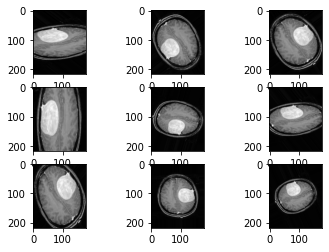

In [54]:
# example of image augmentation for single image
# see more options here: https://keras.io/preprocessing/image/

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img("brain_tumor_dataset/yes/Y1.jpg")
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(
        zoom_range=0.5,
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip=True)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [0]:

train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.5,

        horizontal_flip=True,
        vertical_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainingdata,
        directory=None,
        x_col="X", # Actual column names from data
        y_col="y",
        target_size=(224, 224),
        batch_size=1,
        class_mode='binary',shuffle=True)


Found 202 validated image filenames belonging to 2 classes.


In [0]:

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=testdata,
        directory=None,
        x_col="X",
        y_col="y",
        target_size=(224, 224),
        batch_size=1,
        class_mode='binary')



Found 51 validated image filenames belonging to 2 classes.


In [0]:
#Build a model to fit below
opt=SGD(lr=.001)

model = Sequential()
model.add(Dense(64,  input_shape=(224, 224, 3), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid')) 
                                            
# Compile model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.


      # fits the model on batches with real-time data augmentation:
      model.fit(train_generator,
                    steps_per_epoch=len(trainingdata) / 1, epochs=50, #steps per epoch should be data samples/ image batch size but we have a small dataset, 
                                                                      #so we do not adjust our data into batches.
                    validation_data=validation_generator)

Epoch 1/50
202/202 [==============================] - 4s 20ms/step - loss: 0.6714 - acc: 0.5990 - val_loss: 0.6578 - val_acc: 0.5294
Epoch 2/50
202/202 [==============================] - 4s 18ms/step - loss: 0.6422 - acc: 0.6337 - val_loss: 0.6554 - val_acc: 0.5294
Epoch 3/50
202/202 [==============================] - 4s 19ms/step - loss: 0.6455 - acc: 0.6683 - val_loss: 0.6659 - val_acc: 0.5294
Epoch 4/50
202/202 [==============================] - 4s 18ms/step - loss: 0.6401 - acc: 0.6436 - val_loss: 0.6348 - val_acc: 0.6863
Epoch 5/50
202/202 [==============================] - 4s 18ms/step - loss: 0.6410 - acc: 0.6535 - val_loss: 0.6312 - val_acc: 0.6667
Epoch 6/50
202/202 [==============================] - 4s 19ms/step - loss: 0.6180 - acc: 0.6634 - val_loss: 0.7626 - val_acc: 0.5294
Epoch 7/50
202/202 [==============================] - 4s 19ms/step - loss: 0.6212 - acc: 0.6634 - val_loss: 0.6330 - val_acc: 0.6667
Epoch 8/50
202/202 [==============================] - 4s 19ms/step - 